### "The Earth is what we all have in common."
-Wendell Berry

Disclamer: I know some pieces of code are messy yet, for now my purpose is to test approaches, then to clean up the code

Humanity develops civilizations quickly, discover new technologies rapidly, but relatively recently we stopped and started to think what we do to our Earth. Air pollutions, oceans depletions, erroded soils is just a few terms humans are accounted for. Days when we will happily live on Mars do not seem close (and who knows how we might disrupt this planet too) so the best way is to care about our Earth.

My purpose with this project is to explore trends of air pollution, not to tell what we should do. But if at least someone will stop and think about our impact on the world around my work will not be in wain.

I was switching back and forth between data, the main reason for it being my insentive. I wanted a model that would predict pollutant gases for particular region but was not able to find any good dataset for it. Finally, EPA provides tones of data for USA. Here I will use a subset of the data. Full database can be found at https://aqs.epa.gov/aqsweb/airdata/download_files.html. Lookup for county codes you can at https://aqs.epa.gov/aqsweb/documents/codetables/states_and_counties.html Precisely the one I am using I uploaded to Kaggle and it is attached to the notebook.

The subset I will consider is daily measures of SO2 concentration in the air in Philadelphia county, PA. Generaly with minor tweaks you can run the notebook for any other county. And yet I will exlore the data throught USA too.

### Imports & preconfigurations

In [1]:
# Uncomment if you do not have folium installed
# !pip3 install folium

In [1]:
!pip3 install jovian --quiet

In [2]:
!pip3 install git+https://github.com/Kaggle/kaggle-api.git --upgrade --quiet

In [5]:
def setup_local(kaggle_creds='kaggle.json'):
    import os
    import json
    with open(kaggle_creds, 'r') as f:
        creds = json.loads(f.read())
    os.environ['KAGGLE_USERNAME']=creds['username']
    os.environ['KAGGLE_KEY']=creds['key']
    os.system('kaggle datasets download -d so2-emissions-daily-summary-data')
    os.system('unzip so2-emissions-daily-summary-data.zip')
    return ''

# provide a kaggle.json credentials and
# uncomment the line if you run localy
#
# data_dir = setup_local()

In [6]:
# !kaggle datasets download -d so2-emissions-daily-summary-data

 94%|███████████████████████████████████▋  | 10.0M/10.6M [00:01<00:00, 7.91MB/s]
100%|██████████████████████████████████████| 10.6M/10.6M [00:01<00:00, 6.99MB/s]


In [7]:
# !unzip so2-emissions-daily-summary-data.zip

Archive:  so2-emissions-daily-summary-data.zip
  inflating: daily_42401_2017/daily_42401_2017.csv  
  inflating: daily_42401_2018.csv    
  inflating: daily_42401_2019.csv    


In [248]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
import torch.nn.functional as F
from torch.optim import Adam
import jovian
### uncomment as needed ###
# import geopandas as gpd
# import folium
# from folium.plugins import HeatMap
from tqdm import tqdm

%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 5);

In [8]:
project_name = 'air-pollution-case'
author = 'Valentyna Fihurska'

### Basic EDA

Let us see locations from where the pollution comes from, or at least where we have 'latitude' and 'longitude' values. Or probably something is missing? P.S. Be patient, we have quite a lot of data to map.

In [11]:
pol_df = pd.read_csv('daily_42401_2017/daily_42401_2017.csv')

Update: folium interactive map is not supported in most environments so I commented them out and used IPython utility instead. Feel free to use folium if you have it in environment if you wish so.

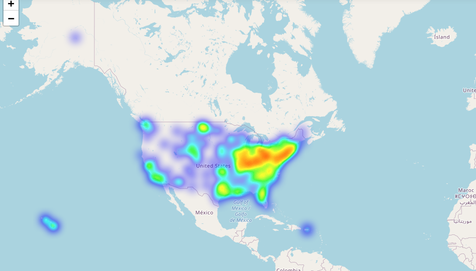

In [3]:
from IPython.display import Image
Image(filename='rsz_screenshot_from_2020-06-21_16-36-19.png')

In [4]:
### uncomment as needed ###

"""
pol_df
samp = pol_df.loc[pol_df['Latitude'].notnull()]
map_sample = folium.Map(location=[50,-85], zoom_start=3)
HeatMap(data=samp[['Latitude', 'Longitude']], radius=10).add_to(map_sample)
map_sample
"""

"\npol_df\nsamp = pol_df.loc[pol_df['Latitude'].notnull()]\nmap_sample = folium.Map(location=[50,-85], zoom_start=3)\nHeatMap(data=samp[['Latitude', 'Longitude']], radius=10).add_to(map_sample)\nmap_sample\n"

Now I will narrow it down to the site of interest and add data for 2018 and 2019.

In [13]:
p2018 = pd.read_csv('daily_42401_2018.csv')
p2019 = pd.read_csv('daily_42401_2019.csv')
pol_df = pol_df.loc[(pol_df['County Code']==101) & (pol_df['State Code']==42)]
p2018 = p2018.loc[(p2018['County Code']==101) & (p2018['State Code']==42)]
p2019 = p2019.loc[(p2019['County Code']==101) & (p2019['State Code']==42)]
pol_df = pd.concat([pol_df, p2018, p2019], axis=0)
del p2018, p2019
pol_df.head()

,State Code,County Code,Site Num,Parameter Code,POC,Latitude,Longitude,Datum,Parameter Name,Sample Duration,...,AQI,Method Code,Method Name,Local Site Name,Address,State Name,County Name,City Name,CBSA Name,Date of Last Change
266523,42,101,48,42401,2,39.991389,-75.080833,WGS84,Sulfur dioxide,1 HOUR,...,3.0,100.0,INSTRUMENTAL - ULTRAVIOLET FLUORESCENCE,North East Waste (NEW),"3000 LEWIS ST. (NEAR BATH ST.) Philadelphia, P...",Pennsylvania,Philadelphia,Philadelphia,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",2018-05-25
266524,42,101,48,42401,2,39.991389,-75.080833,WGS84,Sulfur dioxide,1 HOUR,...,1.0,100.0,INSTRUMENTAL - ULTRAVIOLET FLUORESCENCE,North East Waste (NEW),"3000 LEWIS ST. (NEAR BATH ST.) Philadelphia, P...",Pennsylvania,Philadelphia,Philadelphia,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",2018-05-25
266525,42,101,48,42401,2,39.991389,-75.080833,WGS84,Sulfur dioxide,1 HOUR,...,1.0,100.0,INSTRUMENTAL - ULTRAVIOLET FLUORESCENCE,North East Waste (NEW),"3000 LEWIS ST. (NEAR BATH ST.) Philadelphia, P...",Pennsylvania,Philadelphia,Philadelphia,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",2018-05-25
266526,42,101,48,42401,2,39.991389,-75.080833,WGS84,Sulfur dioxide,1 HOUR,...,9.0,100.0,INSTRUMENTAL - ULTRAVIOLET FLUORESCENCE,North East Waste (NEW),"3000 LEWIS ST. (NEAR BATH ST.) Philadelphia, P...",Pennsylvania,Philadelphia,Philadelphia,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",2018-05-25
266527,42,101,48,42401,2,39.991389,-75.080833,WGS84,Sulfur dioxide,1 HOUR,...,3.0,100.0,INSTRUMENTAL - ULTRAVIOLET FLUORESCENCE,North East Waste (NEW),"3000 LEWIS ST. (NEAR BATH ST.) Philadelphia, P...",Pennsylvania,Philadelphia,Philadelphia,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",2018-05-25


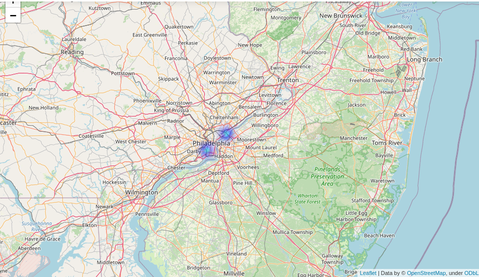

In [5]:
from IPython.display import Image
Image(filename='rsz_screenshot_from_2020-06-21_16-36-29.png') 

In [6]:
### uncomment as needed ###

"""
samp = pol_df.loc[pol_df['Latitude'].notnull()]
map_sample = folium.Map(location=[40,-75], zoom_start=9)
HeatMap(data=samp[['Latitude', 'Longitude']], radius=10).add_to(map_sample)
map_sample
"""

"\nsamp = pol_df.loc[pol_df['Latitude'].notnull()]\nmap_sample = folium.Map(location=[40,-75], zoom_start=9)\nHeatMap(data=samp[['Latitude', 'Longitude']], radius=10).add_to(map_sample)\nmap_sample\n"

In [15]:
pol_df.isnull().sum()

State Code                0
County Code               0
Site Num                  0
Parameter Code            0
POC                       0
Latitude                  0
Longitude                 0
Datum                     0
Parameter Name            0
Sample Duration           0
Pollutant Standard        0
Date Local                0
Units of Measure          0
Event Type                0
Observation Count         0
Observation Percent       0
Arithmetic Mean           0
1st Max Value             0
1st Max Hour              0
AQI                    2156
Method Code            2156
Method Name               0
Local Site Name           0
Address                   0
State Name                0
County Name               0
City Name                 0
CBSA Name                 0
Date of Last Change       0
dtype: int64

Many values are intuitive as for what that means but some are not. Let's explain them:
> POC is a code used to distinguish between different monitors at one site that are measuring a parameter. For example, the first monitor established to measure CO at a site would have POC = "1". If an additional monitor were established at the same site to measure CO, that monitor would have POC = "2". However, if a new instrument were installed to replace the original instrument used as the first monitor, that would be the same monitor and it would have POC = "1". For criteria pollutants, data from different sampling methods should only be stored under the same POC if the sampling intervals are the same and the methods or references are equivalent. For sites where duplicate sampling is being conducted by multiple agencies or one agency with multiple samplers, multiple POC's must be utilized to store all samples. For non-criteria pollutants, data from multiple sampling methods can be stored under the same POC if the sampling intervals are the same. <br><br>
> The AQI is an index for reporting daily air quality. It tells you how clean or polluted your air is, and what associated health effects might be a concern for you. The AQI focuses on health effects you may experience within a few hours or days after breathing polluted air. \[...\] An AQI value of 100 generally corresponds to the national air quality standard for the pollutant, which is the level EPA has set to protect public health. AQI values below 100 are generally thought of as satisfactory. When AQI values are above 100, air quality is considered to be unhealthy-at first for certain sensitive groups of people, then for everyone as AQI values get higher. 
<br>https://cfpub.epa.gov/airnow/index.cfm?action=aqibasics.aqi

To put it simply, POC could be thought of as 'id' of the measurement device. AQI tells us how polluted the air is, the lower AQI the better for human health and the health of the ecosystem.[](http://)

In [16]:
pol_df.shape

(4313, 29)

Let us get rid of columns we will not need (for now at least)

In [112]:
to_drop = ['State Code', 'County Code', 'Site Num', 
           'Parameter Code', 'Latitude', 'Longitude',
          'Parameter Name', 'Sample Duration', 
           'Pollutant Standard']
df = pol_df.drop(to_drop, axis=1)
df.tail()

,POC,Datum,Date Local,Units of Measure,Event Type,Observation Count,Observation Percent,Arithmetic Mean,1st Max Value,1st Max Hour,AQI,Method Code,Method Name,Local Site Name,Address,State Name,County Name,City Name,CBSA Name,Date of Last Change
251038,1,WGS84,2019-12-27,Parts per billion,None,8,100.0,1.175000,1.7,14,NaN,NaN,-,Ritner (RIT),24TH & RITNER STREETS,Pennsylvania,Philadelphia,Philadelphia,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",2020-03-11
251039,1,WGS84,2019-12-28,Parts per billion,None,6,75.0,1.466667,2.2,8,NaN,NaN,-,Ritner (RIT),24TH & RITNER STREETS,Pennsylvania,Philadelphia,Philadelphia,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",2020-03-11
251040,1,WGS84,2019-12-29,Parts per billion,None,8,100.0,1.650000,3.2,8,NaN,NaN,-,Ritner (RIT),24TH & RITNER STREETS,Pennsylvania,Philadelphia,Philadelphia,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",2020-03-11
251041,1,WGS84,2019-12-30,Parts per billion,None,6,75.0,0.650000,0.7,2,NaN,NaN,-,Ritner (RIT),24TH & RITNER STREETS,Pennsylvania,Philadelphia,Philadelphia,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",2020-03-11
251042,1,WGS84,2019-12-31,Parts per billion,None,8,100.0,0.875000,1.2,20,NaN,NaN,-,Ritner (RIT),24TH & RITNER STREETS,Pennsylvania,Philadelphia,Philadelphia,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",2020-03-11


In [113]:
def get_uniques(df):
    
    for col in df.columns:
        if df[col].dtype=='object' and col != 'Date Local':
            print(f'Unique values for {col}: {df[col].unique()}')

get_uniques(df)

Unique values for Datum: ['WGS84']
Unique values for Units of Measure: ['Parts per billion']
Unique values for Event Type: ['None']
Unique values for Method Name: ['INSTRUMENTAL - ULTRAVIOLET FLUORESCENCE' ' - ']
Unique values for Local Site Name: ['North East Waste (NEW)' 'Ritner (RIT)']
Unique values for Address: ['3000 LEWIS ST. (NEAR BATH ST.) Philadelphia, PA. 19137'
 '24TH & RITNER STREETS']
Unique values for State Name: ['Pennsylvania']
Unique values for County Name: ['Philadelphia']
Unique values for City Name: ['Philadelphia']
Unique values for CBSA Name: ['Philadelphia-Camden-Wilmington, PA-NJ-DE-MD']
Unique values for Date of Last Change: ['2018-05-25' '2018-05-24' '2019-03-15' '2020-03-11']


In [114]:
df.drop(['Datum', 'Units of Measure', 'Event Type', 
         'State Name', 'County Name', 'City Name',
        'CBSA Name'], axis=1, inplace=True)
df.loc[:, 'Date Local'] = pd.to_datetime(df['Date Local'])
df.set_index('Date Local', inplace=True)
df

,POC,Observation Count,Observation Percent,Arithmetic Mean,1st Max Value,1st Max Hour,AQI,Method Code,Method Name,Local Site Name,Address,Date of Last Change
Date Local,,,,,,,,,,,,
2017-01-01,2,24,100.0,1.720833,2.5,19,3.0,100.0,INSTRUMENTAL - ULTRAVIOLET FLUORESCENCE,North East Waste (NEW),"3000 LEWIS ST. (NEAR BATH ST.) Philadelphia, P...",2018-05-25
2017-01-02,2,22,92.0,1.204545,1.7,4,1.0,100.0,INSTRUMENTAL - ULTRAVIOLET FLUORESCENCE,North East Waste (NEW),"3000 LEWIS ST. (NEAR BATH ST.) Philadelphia, P...",2018-05-25
2017-01-03,2,24,100.0,1.254167,1.5,11,1.0,100.0,INSTRUMENTAL - ULTRAVIOLET FLUORESCENCE,North East Waste (NEW),"3000 LEWIS ST. (NEAR BATH ST.) Philadelphia, P...",2018-05-25
2017-01-04,2,19,79.0,2.173684,6.9,4,9.0,100.0,INSTRUMENTAL - ULTRAVIOLET FLUORESCENCE,North East Waste (NEW),"3000 LEWIS ST. (NEAR BATH ST.) Philadelphia, P...",2018-05-25
2017-01-05,2,24,100.0,1.820833,2.9,5,3.0,100.0,INSTRUMENTAL - ULTRAVIOLET FLUORESCENCE,North East Waste (NEW),"3000 LEWIS ST. (NEAR BATH ST.) Philadelphia, P...",2018-05-25
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,1,8,100.0,1.175000,1.7,14,NaN,NaN,-,Ritner (RIT),24TH & RITNER STREETS,2020-03-11
2019-12-28,1,6,75.0,1.466667,2.2,8,NaN,NaN,-,Ritner (RIT),24TH & RITNER STREETS,2020-03-11
2019-12-29,1,8,100.0,1.650000,3.2,8,NaN,NaN,-,Ritner (RIT),24TH & RITNER STREETS,2020-03-11


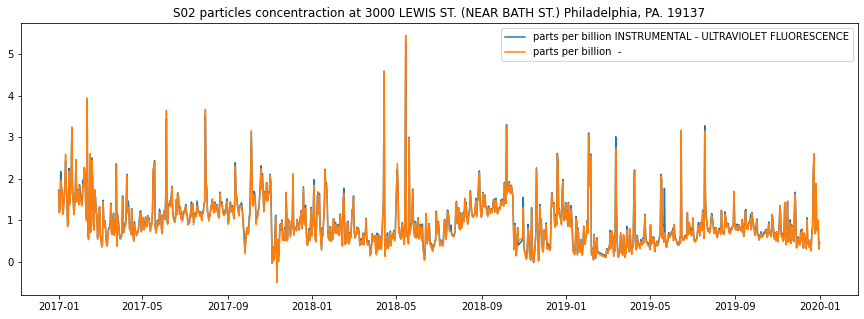

In [115]:
t11 = df.loc[(df['Address']==df['Address'].unique()[0]) & (
    df['Method Name']==df['Method Name'].unique()[0])]
t12 = df.loc[(df['Address']==df['Address'].unique()[0]) & (
    df['Method Name']==df['Method Name'].unique()[1])]
t21 = df.loc[(df['Address']==df['Address'].unique()[1]) & (
    df['Method Name']==df['Method Name'].unique()[0])]
t22 = df.loc[(df['Address']==df['Address'].unique()[1]) & (
    df['Method Name']==df['Method Name'].unique()[1])]
plt.plot(t11['Arithmetic Mean'], label='parts per billion {}'.format(t11['Method Name'][0]))
plt.plot(t12['Arithmetic Mean'], label='parts per billion {}'.format(t12['Method Name'][0]))
plt.title('S02 particles concentraction at {}'.format(t11['Address'][0]))
plt.legend()
#plt.plot(t21['Observation Count'])
#plt.plot(t22['Observation Count'])

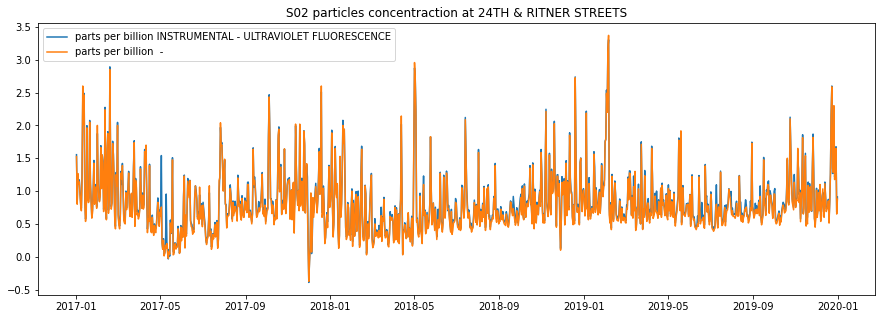

In [116]:
plt.plot(t21['Arithmetic Mean'], label='parts per billion {}'.format(t21['Method Name'][0]))
plt.plot(t22['Arithmetic Mean'], label='parts per billion {}'.format(t22['Method Name'][0]))
plt.title('S02 particles concentraction at {}'.format(t21['Address'][0]))
plt.legend()

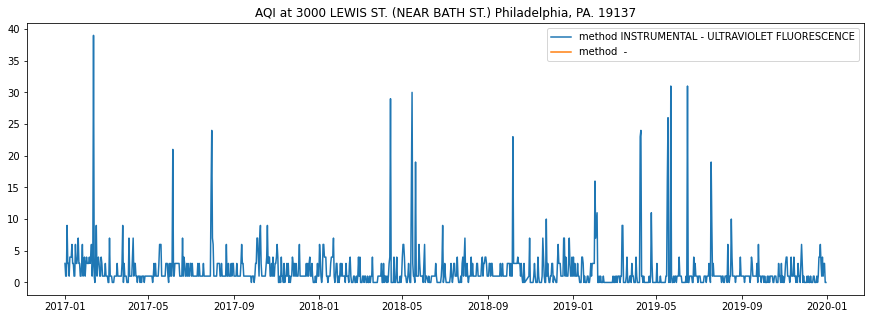

In [117]:
plt.plot(t11['AQI'], label='method {}'.format(t11['Method Name'][0]))
plt.plot(t12['AQI'], label='method {}'.format(t12['Method Name'][0]))
plt.title('AQI at {}'.format(t11['Address'][0]))
plt.legend()

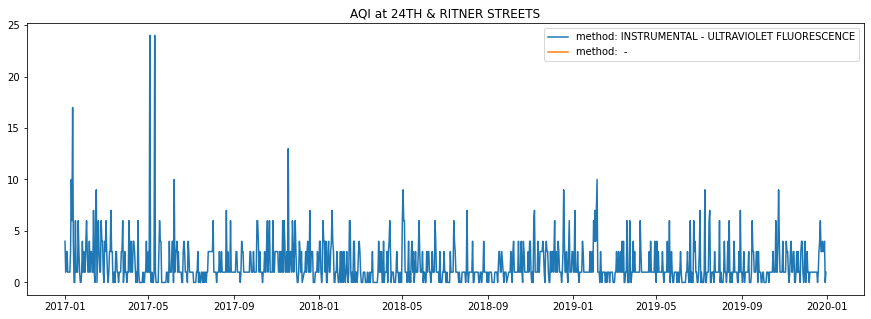

In [118]:
plt.plot(t21['AQI'], label='method: {}'.format(t21['Method Name'][0]))
plt.plot(t22['AQI'], label='method: {}'.format(t22['Method Name'][0]))
plt.title('AQI at {}'.format(t21['Address'][0]))
plt.legend()

It is clear for the first station there is no difference in method of measurement. First attempt I tired it I have had missing AQI columns (which is not the case now and seems to be the case for some stations). If you will play around this dataset I have developed a simple model to impute those values since there is a strong link between maximum value and AQI. You might use it for your case.

In [119]:
df = df.loc[(df['Address']==df['Address'].unique()[0]) & (
    df['Method Name']==df['Method Name'].unique()[0])]
df

,POC,Observation Count,Observation Percent,Arithmetic Mean,1st Max Value,1st Max Hour,AQI,Method Code,Method Name,Local Site Name,Address,Date of Last Change
Date Local,,,,,,,,,,,,
2017-01-01,2,24,100.0,1.720833,2.5,19,3.0,100.0,INSTRUMENTAL - ULTRAVIOLET FLUORESCENCE,North East Waste (NEW),"3000 LEWIS ST. (NEAR BATH ST.) Philadelphia, P...",2018-05-25
2017-01-02,2,22,92.0,1.204545,1.7,4,1.0,100.0,INSTRUMENTAL - ULTRAVIOLET FLUORESCENCE,North East Waste (NEW),"3000 LEWIS ST. (NEAR BATH ST.) Philadelphia, P...",2018-05-25
2017-01-03,2,24,100.0,1.254167,1.5,11,1.0,100.0,INSTRUMENTAL - ULTRAVIOLET FLUORESCENCE,North East Waste (NEW),"3000 LEWIS ST. (NEAR BATH ST.) Philadelphia, P...",2018-05-25
2017-01-04,2,19,79.0,2.173684,6.9,4,9.0,100.0,INSTRUMENTAL - ULTRAVIOLET FLUORESCENCE,North East Waste (NEW),"3000 LEWIS ST. (NEAR BATH ST.) Philadelphia, P...",2018-05-25
2017-01-05,2,24,100.0,1.820833,2.9,5,3.0,100.0,INSTRUMENTAL - ULTRAVIOLET FLUORESCENCE,North East Waste (NEW),"3000 LEWIS ST. (NEAR BATH ST.) Philadelphia, P...",2018-05-25
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,2,23,96.0,0.760870,1.3,15,1.0,100.0,INSTRUMENTAL - ULTRAVIOLET FLUORESCENCE,North East Waste (NEW),"3000 LEWIS ST. (NEAR BATH ST.) Philadelphia, P...",2020-03-11
2019-12-28,2,23,96.0,0.878261,2.5,8,3.0,100.0,INSTRUMENTAL - ULTRAVIOLET FLUORESCENCE,North East Waste (NEW),"3000 LEWIS ST. (NEAR BATH ST.) Philadelphia, P...",2020-03-11
2019-12-29,2,23,96.0,0.960870,2.6,5,3.0,100.0,INSTRUMENTAL - ULTRAVIOLET FLUORESCENCE,North East Waste (NEW),"3000 LEWIS ST. (NEAR BATH ST.) Philadelphia, P...",2020-03-11


### Preprocessing

In [120]:
df.drop(['Address', 'Method Name', 'Method Code', 'Local Site Name', 
         'Date of Last Change', 'POC', 'Observation Count', 
         'Observation Percent', '1st Max Hour'], axis=1, inplace=True)
df

/home/val/.local/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Arithmetic Mean,1st Max Value,AQI
Date Local,,,
2017-01-01,1.720833,2.5,3.0
2017-01-02,1.204545,1.7,1.0
2017-01-03,1.254167,1.5,1.0
2017-01-04,2.173684,6.9,9.0
2017-01-05,1.820833,2.9,3.0
...,...,...,...
2019-12-27,0.760870,1.3,1.0
2019-12-28,0.878261,2.5,3.0
2019-12-29,0.960870,2.6,3.0


In [121]:
df.isnull().sum()

Arithmetic Mean    0
1st Max Value      0
AQI                0
dtype: int64

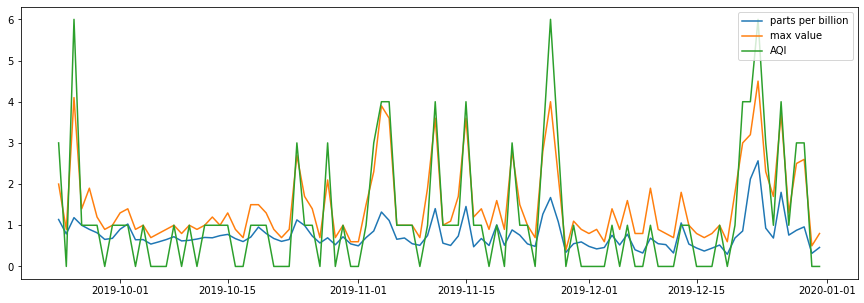

In [122]:
plt.plot(df.dropna()['Arithmetic Mean'][-100:], label='parts per billion')
plt.plot(df.dropna()['1st Max Value'][-100:], label='max value')
plt.plot(df.dropna()['AQI'][-100:], label='AQI')
plt.legend(loc = 'upper right')

In [123]:
df

,Arithmetic Mean,1st Max Value,AQI
Date Local,,,
2017-01-01,1.720833,2.5,3.0
2017-01-02,1.204545,1.7,1.0
2017-01-03,1.254167,1.5,1.0
2017-01-04,2.173684,6.9,9.0
2017-01-05,1.820833,2.9,3.0
...,...,...,...
2019-12-27,0.760870,1.3,1.0
2019-12-28,0.878261,2.5,3.0
2019-12-29,0.960870,2.6,3.0


Nice! We can see a strong relationship between maximum observed particulates in a day and air quility index. This relationship seems to hold true to the mean parts per billion although this is not as appearent. Anyway, now we can impute our missing AQI much smarter. Let's build a tiny slightly better than linear model for that. Use it as needed (here we do not need this step)

In [124]:
def save_n_commit(model, metrics=None):
    
    kw = ['arch', 'epochs', 'lr', 
          'scheduler', 'weight_decay', 
          'grad_clip', 'opt', 'val_loss',
          'val_score', 'train_loss', 
          'train_time', 'loss_func']
    
    if metrics:
        for k in kw:
            try:
                metrics[k]
            except Exception:
                metrics[k] = None
    else:
        metrics = {k: None for k in kw}
    
    weights_fname = '{}-{}ep-{}lr.pth'.format(metrics['arch'],
                                              metrics['epochs'],
                                              metrics['lr'])
    torch.save(model.state_dict(), weights_fname)
    jovian.reset()

    jovian.log_hyperparams(arch=metrics['arch'], 
                           epochs=metrics['epochs'], 
                           lr=metrics['lr'], 
                           scheduler=metrics['scheduler'], 
                           weight_decay=metrics['weight_decay'], 
                           grad_clip=metrics['grad_clip'],
                           opt=metrics['opt'],
                           val_loss=metrics['val_loss'],
                           val_score=metrics['val_score'],
                           train_loss=metrics['train_loss'],
                           train_time=metrics['train_time'],
                          loss_func=metrics['loss_func'])
    
    jovian.commit(project=project_name, 
                  environment=None, 
                  outputs=[weights_fname])
    return True



In [125]:
def impute_aqi(aqi, max_values, mv_pred, lr=0.0001,
               epochs=50, save=True):
    linreg = nn.Linear(1, 1)
    loss_f = F.mse_loss
    opt = torch.optim.Adam(linreg.parameters(), lr=lr)
    if isinstance(aqi, np.ndarray):
        aqi_max = np.max(aqi)
        aqi = torch.from_numpy(aqi/aqi_max)
    if isinstance(max_values, np.ndarray):
        max_values_max = np.max(max_values)
        max_values = torch.from_numpy(max_values/max_values_max)
    if isinstance(mv_pred, np.ndarray):
        mv_pred_max = np.max(mv_pred)
        mv_pred = torch.from_numpy(mv_pred/max_values_max)
    for epoch in range(0, epochs):
        
        for x, y in zip(aqi, max_values):
            out = F.relu(linreg(x))
            loss = loss_f(out, y)
            loss.backward()
            opt.step()
            opt.zero_grad()
        if (epoch+1) % 10 == 0:
            print('Epoch [{}/{}], Loss: {:.4f}'.format(
                epoch+1, epochs, loss.item()))
    if save:
        save_n_commit(model, metrics={'arch': 'Linear(1, 1)',
                                     'epochs': epochs,
                                     'train_loss': loss.item(),
                                      'opt': opt.__name__,
                                     'lr': lr, 
                                      'loss_func': loss_f.__name__})
    l = [round(linreg(x).item()*max_values_max) for x in mv_pred]
    return l

# if you have NaN values for AQI use similar procedure for 
# value imputation
'''
aqi = np.array([[x] for x in df.dropna()['AQI'].values], 
    dtype=np.float32)
max_values = np.array([[x] for x in df.dropna()['1st Max Value'].values], 
    dtype=np.float32)
mv_pred = np.array([[x] for x in df.loc[df['AQI'].isnull()]['1st Max Value'].values], 
    dtype=np.float32)
l = impute_aqi(aqi, max_values, mv_pred)
df.loc[df['AQI'].isnull(), 'AQI'] = l
'''

"\naqi = np.array([[x] for x in df.dropna()['AQI'].values], \n    dtype=np.float32)\nmax_values = np.array([[x] for x in df.dropna()['1st Max Value'].values], \n    dtype=np.float32)\nmv_pred = np.array([[x] for x in df.loc[df['AQI'].isnull()]['1st Max Value'].values], \n    dtype=np.float32)\nl = impute_aqi(aqi, max_values, mv_pred)\ndf.loc[df['AQI'].isnull(), 'AQI'] = l\n"

In [126]:
def rescale(df):
    scalers = []
    for col in df.columns:
        if np.max(df[col].values)>1.:
            scaler = MinMaxScaler()
            scaler.fit(df[col].values.reshape(-1, 1))
            df.loc[:, col] = scaler.transform(df[col].values.reshape(-1, 1))
            scalers.append(scaler)
    return df, scalers

df, scalers = rescale(df)
df

/home/val/.local/lib/python3.6/site-packages/pandas/core/indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/home/val/.local/lib/python3.6/site-packages/pandas/core/indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/home/val/.local/lib/python3.6/site-packages/pandas/core/indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

,Arithmetic Mean,1st Max Value,AQI
Date Local,,,
2017-01-01,0.386072,0.099265,0.076923
2017-01-02,0.296320,0.069853,0.025641
2017-01-03,0.304946,0.062500,0.025641
2017-01-04,0.464796,0.261029,0.230769
2017-01-05,0.403456,0.113971,0.076923
...,...,...,...
2019-12-27,0.219191,0.055147,0.025641
2019-12-28,0.239598,0.099265,0.076923
2019-12-29,0.253959,0.102941,0.076923


## Dataset and DataLoader

The key point here to keep in mind is that we should not shuffle our data since our goal is to predict values based on date. Still, for starters let us not overcomplicate the matter and build not too sophisticated dataset and model.

In [57]:
temp_df = df.copy()
temp_df = temp_df.reset_index().drop('Date Local', axis=1)
temp_df

,Arithmetic Mean,1st Max Value,AQI
0,0.386072,0.099265,0.076923
1,0.296320,0.069853,0.025641
2,0.304946,0.062500,0.025641
3,0.464796,0.261029,0.230769
4,0.403456,0.113971,0.076923
...,...,...,...
1066,0.219191,0.055147,0.025641
1067,0.239598,0.099265,0.076923
1068,0.253959,0.102941,0.076923
1069,0.142096,0.025735,0.000000


In [58]:
class PollutionDataset(Dataset):
    
    def __init__(self, frame):
        super().__init__()
        self.frame = frame
        
    def __len__(self):
        return self.frame.shape[0]
    
    def __getitem__(self, ind):
        x = torch.tensor(ind).float()
        y = self.frame.loc[ind, :].values.astype(np.float32)
        return x, y

In [59]:
test_date = temp_df.index[int(len(temp_df)*0.85)]
batch_size = 16
train_df = PollutionDataset(temp_df[:test_date])
val_df = PollutionDataset(temp_df[test_date:])
train_loader = DataLoader(train_df,
                         shuffle=False)
val_loader = DataLoader(val_df,
                         shuffle=False)

In [60]:
temp_df[:test_date]

,Arithmetic Mean,1st Max Value,AQI
0,0.386072,0.099265,0.076923
1,0.296320,0.069853,0.025641
2,0.304946,0.062500,0.025641
3,0.464796,0.261029,0.230769
4,0.403456,0.113971,0.076923
...,...,...,...
905,0.656061,0.514706,0.487179
906,0.356752,0.253676,0.230769
907,0.273611,0.073529,0.025641
908,0.255471,0.088235,0.076923


### Modeling, training, experimenting

In [61]:
class PollutionModel(nn.Module):
    
    def __init__(self, out_features=3):
        super().__init__()
        self.input = nn.Linear(1, 32)
        self.lin1 = nn.Linear(32, 64)
        self.lin2 = nn.Linear(64, 128)
        self.lin3 = nn.Linear(128, 32)
        self.out = nn.Linear(32, 3)
    
    def forward(self, x):
        x = F.relu(self.input(x))
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = F.relu(self.lin3(x))
        return F.relu(self.out(x))

In [62]:
model = PollutionModel()

In [63]:
epochs = 50
lr = 0.001

loss_f = F.mse_loss

In [64]:
train_loader.dataset[0]

(tensor(0.), array([0.38607195, 0.0992647 , 0.07692308], dtype=float32))

In [65]:
def fit(model, epochs=50, lr=0.001, loss_f=F.mse_loss, save=True):

    opt = Adam(model.parameters(), lr=lr)
    total_loss = []
    for epoch in tqdm(range(epochs)):
        model.train()
        for sample in train_loader:
            x, y = sample
            model.zero_grad()
            out = model(x)
            loss = loss_f(out, y)
            loss.backward()
            opt.step()
            total_loss.append(loss.item())
            opt.zero_grad()
    t_loss = np.array(total_loss).mean()
    print(t_loss)
    if save:
        save_n_commit(model, metrics={'arch': 
                                      'Lin_1x32, Lin32x64, \
                                      Lin64x128, Lin128x32, Lin32x3',
                                     'epochs': epochs, 'lr': lr,
                                     'loss_func': loss_f.__name__,
                                     'opt': str(opt),
                                     'train_loss': t_loss})
    return model

model = fit(model)

  0%|          | 0/50 [00:00<?, ?it/s]/home/val/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Using a target size (torch.Size([1, 3])) that is different to the input size (torch.Size([3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  # This is added back by InteractiveShellApp.init_path()
100%|██████████| 50/50 [09:16<00:00, 11.12s/it]


0.03441063705281928
[jovian] Hyperparams logged.


<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "erelin6613/air-pollution-case" on https://jovian.ml/
[jovian] Uploading notebook..
[jovian] Uploading additional outputs...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ml/erelin6613/air-pollution-case


In [66]:
def predict(model, val_loader):
    
    preds = []
    model.eval()
    for sample in train_loader:
        x, y = sample
        model.zero_grad()
        out = model(x)
        preds.append(out.detach().numpy())
    return np.array(preds)

preds = predict(model, val_loader)
temp_df[test_date:]['AQI'], [x[-1] for x in preds]

(910     0.025641
 911     0.025641
 912     0.025641
 913     0.025641
 914     0.025641
           ...   
 1066    0.025641
 1067    0.076923
 1068    0.076923
 1069    0.000000
 1070    0.000000
 Name: AQI, Length: 161, dtype: float64,
 [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0

That did not quite work. Why? First, our model does not know it is a sequencial data, these integers index were our sequence. Second, the integers themselves were treated as pure numerical values. Lastly, we would have some predictions if we feed the model the data it has seen before, i.e. numbers up to 910, other values our model not just has not seen, it does not know what to do with them. We need much smarter approach.

We need our model to consume sequence of elements (input) and make it predict the next item in the sequence (output). So here we will define some utils to help us achieve what we want. For now let's restrict our task to predict 'AQI' column only. Later we can expend the approach to other values too. Check out <a href='https://www.curiousily.com/posts/time-series-forecasting-with-lstm-for-daily-coronavirus-cases/'>this</a> blog post to see where I've insiration from.

In [500]:
def get_sequences(df, seq_len):
    xs = []
    ys = []
    for i in range(len(df)-seq_len-1):
        x = df[i:(i+seq_len)].values
        y = df.loc[df.index[i+seq_len]]#.values
        xs.append(x)
        ys.append(y)
    #print(np.array(xs).shape)

    return np.array(xs), np.array(ys)

s_len = 7
test_size = int(len(df)*0.85)
train_seq = get_sequences(df.loc[:df.index[test_size], 'AQI'], s_len)
val_seq = get_sequences(df.loc[df.index[test_size]:, 'AQI'], s_len)
train_seq[0].shape, train_seq[1].shape

((903, 7), (903,))

In [68]:
class StatelessModel(nn.Module):
    
    def __init__(self, n_features, n_hidden, seq_len=7, 
                 n_layers=2, out_features=1):
        super().__init__()
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers
        self.lstm = nn.LSTM(n_features, 
                            n_hidden, 
                            n_layers,
                            dropout=0.5)
        self.linear = nn.Linear(n_hidden, out_features)
    
    def reset_hidden_state(self):
        self.hidden = (torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
                       torch.zeros(self.n_layers, self.seq_len, self.n_hidden))
    
    def forward(self, x):
        x = torch.tensor(x).view(1, self.seq_len, -1)
        lstm_out, _ = self.lstm(x.float(), self.hidden)
        last_time_step = lstm_out.view(
            self.seq_len, len(x), self.n_hidden)[-1]
        x = self.linear(last_time_step)
        return torch.flatten(x)

In [71]:
def fit_lstm(model, data, epochs=50, 
             lr=0.0001, loss_f=F.mse_loss,
            save=True):

    optimizer = Adam(model.parameters(), lr=lr)
    x, y = data
    model.train()
    for epoch in range(epochs):
        total_loss = []
        for x_seq, y_seq in zip(x, y):
            model.zero_grad()
            model.reset_hidden_state()
            out = model(np.array([[i] for i in x_seq]))
            loss = loss_f(out, torch.tensor([y_seq]).float())
            loss.backward()
            optimizer.step()
            total_loss.append(loss.item())
            optimizer.zero_grad()
        t_loss = np.array(total_loss).mean()
        print('Epoch: {}, loss: {}'.format(
            epoch, t_loss))
    if save:
        save_n_commit(model, metrics={'arch': 'LSTMx2x256, Lin256x1',
                                     'epochs': epochs, 'lr': lr,
                                     'loss_func': loss_f.__name__,
                                     'opt': str(optimizer),
                                     'train_loss': t_loss})
    return model


In [72]:
model = StatelessModel(1, 256)
model = fit_lstm(model, train_seq)

Epoch: 0, loss: 0.008615814377377864
Epoch: 1, loss: 0.00854637708571665
Epoch: 2, loss: 0.008512742443072803
Epoch: 3, loss: 0.008493268511134527
Epoch: 4, loss: 0.008448725336091433
Epoch: 5, loss: 0.008367272367032594
Epoch: 6, loss: 0.008370148849728616
Epoch: 7, loss: 0.008335134525341716
Epoch: 8, loss: 0.008333896544574584
Epoch: 9, loss: 0.008316049254011169
Epoch: 10, loss: 0.00831004343510685
Epoch: 11, loss: 0.008310968439122369
Epoch: 12, loss: 0.008299208081237353
Epoch: 13, loss: 0.008281352963514534
Epoch: 14, loss: 0.00830573489179797
Epoch: 15, loss: 0.008280207667429462
Epoch: 16, loss: 0.008226629007934767
Epoch: 17, loss: 0.008275523904489032
Epoch: 18, loss: 0.00831387563236567
Epoch: 19, loss: 0.008245221869342671
Epoch: 20, loss: 0.008246555337221703
Epoch: 21, loss: 0.008247341011627272
Epoch: 22, loss: 0.008205104550166422
Epoch: 23, loss: 0.008222313306960757
Epoch: 24, loss: 0.008257680037857177
Epoch: 25, loss: 0.008271522077749026
Epoch: 26, loss: 0.0082473

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "erelin6613/air-pollution-case" on https://jovian.ml/
[jovian] Uploading notebook..
[jovian] Uploading additional outputs...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ml/erelin6613/air-pollution-case


In [73]:
def evaluate(model, val_set, return_preds=True):
    x, y = val_set
    diviance = []
    model.eval()
    total_loss = []
    if return_preds:
        preds = []
    for x_seq, y_seq in tqdm(zip(x, y)):
        model.reset_hidden_state()
        out = model(np.array([[i] for i in x_seq]))
        loss = loss_f(out, torch.tensor([y_seq]).float())
        diviance.append(np.abs(out.detach().item()-y_seq))
        total_loss.append(loss.item())
        if return_preds:
            preds.append(out.detach().numpy()[0])
    mean_loss = np.array(total_loss).mean()
    mean_div = np.array(diviance).mean()
    if return_preds:
        return mean_loss, mean_div, np.array(preds)
    return mean_loss, mean_div

mean_loss, mean_div, preds = evaluate(model, val_seq)
mean_loss, mean_div, preds

153it [00:01, 149.38it/s]


(0.0017375356870937156,
 0.034851544660420716,
 array([0.04802775, 0.04802775, 0.04802775, 0.04802775, 0.04098856,
        0.04802775, 0.04802775, 0.04098856, 0.04098856, 0.04802775,
        0.04802775, 0.04802775, 0.04098856, 0.08019765, 0.04802775,
        0.04098856, 0.04802775, 0.04802775, 0.1025144 , 0.06792097,
        0.04802775, 0.04802775, 0.04802775, 0.04802775, 0.04098856,
        0.04802775, 0.04802775, 0.04802775, 0.04802775, 0.04802775,
        0.04802775, 0.06792097, 0.04802775, 0.04802775, 0.04802775,
        0.04802775, 0.04802775, 0.04098856, 0.04802775, 0.04802775,
        0.04802775, 0.04802775, 0.04802775, 0.04802775, 0.04802775,
        0.04098856, 0.04802775, 0.06792097, 0.06149051, 0.04802775,
        0.04802775, 0.04802775, 0.04802775, 0.04802775, 0.04802775,
        0.06149051, 0.04098856, 0.08019765, 0.04802775, 0.04802775,
        0.04802775, 0.04098856, 0.04802775, 0.04802775, 0.04802775,
        0.04098856, 0.04802775, 0.04098856, 0.04098856, 0.04098856,
 

In [128]:
s_val = scalers[-1].inverse_transform(val_seq[1].reshape(-1, 1))
s_pred = scalers[-1].inverse_transform(preds.reshape(-1, 1)).astype('int')
for v, p in zip(s_val, s_pred):
    print('true:', v, '\tpredicted:', p)

true: [1.] 	predicted: [1]
true: [1.] 	predicted: [1]
true: [1.] 	predicted: [1]
true: [0.] 	predicted: [1]
true: [1.] 	predicted: [1]
true: [1.] 	predicted: [1]
true: [0.] 	predicted: [1]
true: [0.] 	predicted: [1]
true: [1.] 	predicted: [1]
true: [1.] 	predicted: [1]
true: [1.] 	predicted: [1]
true: [0.] 	predicted: [1]
true: [6.] 	predicted: [1]
true: [1.] 	predicted: [3]
true: [0.] 	predicted: [1]
true: [1.] 	predicted: [1]
true: [1.] 	predicted: [1]
true: [10.] 	predicted: [1]
true: [4.] 	predicted: [3]
true: [1.] 	predicted: [2]
true: [1.] 	predicted: [1]
true: [1.] 	predicted: [1]
true: [1.] 	predicted: [1]
true: [0.] 	predicted: [1]
true: [1.] 	predicted: [1]
true: [1.] 	predicted: [1]
true: [1.] 	predicted: [1]
true: [1.] 	predicted: [1]
true: [1.] 	predicted: [1]
true: [1.] 	predicted: [1]
true: [4.] 	predicted: [1]
true: [1.] 	predicted: [2]
true: [1.] 	predicted: [1]
true: [1.] 	predicted: [1]
true: [1.] 	predicted: [1]
true: [1.] 	predicted: [1]
true: [0.] 	predicted: [1]


In [129]:
scalers

[MinMaxScaler(copy=True, feature_range=(0, 1)),
 MinMaxScaler(copy=True, feature_range=(0, 1)),
 MinMaxScaler(copy=True, feature_range=(0, 1))]

Well, we are getting somewhere. We can even say our model is predicting not exactly the values but a sort of 'strench' as to how our value is going to be bigger or lower the next day. But something is missing. Notice here a few things:
* the loss value we are getting is small even though model is not doing well
* model does not ever predicts AQI higher than 2
* the lag we are observing is actually what we want, i.e. given the some sequence we want our model to predict the next value in it <br><br>
Traing with some other column values might help us discover what is off.

In [130]:
train_seq = get_sequences(df.loc[:df.index[test_size], 'Arithmetic Mean'], s_len)
val_seq = get_sequences(df.loc[df.index[test_size]:, 'Arithmetic Mean'], s_len)
model = StatelessModel(1, 256)
model = fit_lstm(model, train_seq)
mean_loss, mean_div, preds = evaluate(model, val_seq)

Epoch: 0, loss: 0.016111138231557305
Epoch: 1, loss: 0.009574950714964088
Epoch: 2, loss: 0.009355241574050975
Epoch: 3, loss: 0.009095326265068522
Epoch: 4, loss: 0.008956813988825172
Epoch: 5, loss: 0.008625232547338848
Epoch: 6, loss: 0.008562622854811675
Epoch: 7, loss: 0.008284572132487128
Epoch: 8, loss: 0.008191138218886954
Epoch: 9, loss: 0.008012172731337917
Epoch: 10, loss: 0.00785479277389266
Epoch: 11, loss: 0.008010994589062959
Epoch: 12, loss: 0.007979928007921888
Epoch: 13, loss: 0.007820426974632878
Epoch: 14, loss: 0.0077985212099004626
Epoch: 15, loss: 0.007973177506278814
Epoch: 16, loss: 0.007837982147493783
Epoch: 17, loss: 0.007895605143705594
Epoch: 18, loss: 0.007893670738606761
Epoch: 19, loss: 0.007889334484798614
Epoch: 20, loss: 0.00790158742241194
Epoch: 21, loss: 0.007811331607095975
Epoch: 22, loss: 0.007756868234028803
Epoch: 23, loss: 0.007594334074488923
Epoch: 24, loss: 0.007797222366344646
Epoch: 25, loss: 0.007769138411559292
Epoch: 26, loss: 0.0076

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "erelin6613/air-pollution-case" on https://jovian.ml/
[jovian] Uploading notebook..
[jovian] Uploading additional outputs...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ml/erelin6613/air-pollution-case


153it [00:00, 164.71it/s]


In [131]:
s_val = scalers[0].inverse_transform(val_seq[1].reshape(-1, 1))
s_pred = scalers[0].inverse_transform(preds.reshape(-1, 1))
for v, p in zip(s_val, s_pred):
    print('true:', v, '\tpredicted:', p)

true: [0.921739] 	predicted: [0.89123696]
true: [0.72381] 	predicted: [0.8310556]
true: [0.813043] 	predicted: [0.7306421]
true: [0.691304] 	predicted: [0.7763072]
true: [0.818182] 	predicted: [0.7138448]
true: [0.686957] 	predicted: [0.7789173]
true: [0.6] 	predicted: [0.71159214]
true: [0.695652] 	predicted: [0.6662001]
true: [0.771429] 	predicted: [0.7160967]
true: [0.804348] 	predicted: [0.7550922]
true: [0.721739] 	predicted: [0.7718862]
true: [0.691304] 	predicted: [0.7295744]
true: [1.234783] 	predicted: [0.7138448]
true: [0.740909] 	predicted: [0.9834031]
true: [0.717391] 	predicted: [0.7394428]
true: [0.671429] 	predicted: [0.7273318]
true: [0.669565] 	predicted: [0.7035318]
true: [1.2] 	predicted: [0.70256317]
true: [1.086957] 	predicted: [0.9668626]
true: [0.865217] 	predicted: [0.91244113]
true: [0.93913] 	predicted: [0.80270636]
true: [0.84] 	predicted: [0.8397264]
true: [0.915] 	predicted: [0.7899748]
true: [0.726087] 	predicted: [0.8276892]
true: [0.704348] 	predicted: [

That is much better, still not good enough. Here is what we might consider to try:
* MinMaxScaler might be not a good fit for our data
* we used stateless LSTM, it might improve model's performance if we did account for it
* our time series does not look like non-stationary as needed for time series problems but some steps to normalize it might help
* initially we are sliding a window of 7 days and trying to predict a value of 8th. It is reasonable to assume the pattern we are trying to capture exposes itself in the other window of time
* there is a possibility the values we are trying to predict either interact in too complex patterns we are unable to put a finger on, posibly it requires some other data on top of the date or it is not dependent on time at all (though I doubt the latter)

Finally, before builing our major air quality predictor we should try convolutional networks. As weird as it might sound, convolutional networks were deployed widely for text generation and classification problems, that is for the same sequence prediction problems. We might get some results too.

In [198]:
class AirModelCNN(nn.Module):
    
    def __init__(self, seq_len=7):
        super().__init__()
        self.seq_len = seq_len
        self.conv1 = nn.Conv1d(1, 64, 2)
        self.conv2 = nn.Conv1d(64, 32, 2)
        self.out = nn.Linear(32*(seq_len-2), 1)
        
    def forward(self, x):
        x = torch.tensor(x).view(1, -1, self.seq_len).float()
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = torch.flatten(x)
        return F.relu(self.out(x))

In [199]:
model = AirModelCNN()

In [205]:
def fit_cnn(model, data, epochs=50, 
             lr=0.0001, loss_f=F.mse_loss,
            save=True):

    optimizer = Adam(model.parameters(), lr=lr)
    x, y = data
    model.train()
    for epoch in range(epochs):
        total_loss = []
        for x_seq, y_seq in zip(x, y):
            model.zero_grad()
            out = model(np.array(x_seq))#([[i] for i in x_seq]))
            loss = loss_f(out, torch.tensor([y_seq]).float())
            loss.backward()
            optimizer.step()
            total_loss.append(loss.item())
            optimizer.zero_grad()
        t_loss = np.array(total_loss).mean()
        print('Epoch: {}, loss: {}'.format(
            epoch, t_loss))
    if save:
        save_n_commit(model, metrics={'arch': 'LSTMx2x256, Lin256x1',
                                     'epochs': epochs, 'lr': lr,
                                     'loss_func': loss_f.__name__,
                                     'opt': str(optimizer),
                                     'train_loss': t_loss})
    return model   

#s_len = 7
#test_size = int(len(df)*0.85)
#train_seq = get_sequences(df.loc[:df.index[test_size], 'AQI'], s_len)
#val_seq = get_sequences(df.loc[df.index[test_size]:, 'AQI'], s_len)
#train_seq[0].shape, train_seq[1].shape

In [206]:
model = fit_cnn(model, train_seq, save=False)

Epoch: 0, loss: 0.008517885590200617
Epoch: 1, loss: 0.008236425966972993
Epoch: 2, loss: 0.007914609216722343
Epoch: 3, loss: 0.007639206943395157
Epoch: 4, loss: 0.007423388967108709
Epoch: 5, loss: 0.007251978973520317
Epoch: 6, loss: 0.007109656527051499
Epoch: 7, loss: 0.007001862934400067
Epoch: 8, loss: 0.006909995133999734
Epoch: 9, loss: 0.006828458542405886
Epoch: 10, loss: 0.006771167008369135
Epoch: 11, loss: 0.006731175142281778
Epoch: 12, loss: 0.006685308100266973
Epoch: 13, loss: 0.006664851323749524
Epoch: 14, loss: 0.006651424223073066
Epoch: 15, loss: 0.006607602060263575
Epoch: 16, loss: 0.006589515323622336
Epoch: 17, loss: 0.0065717572892675154
Epoch: 18, loss: 0.00655530309940201
Epoch: 19, loss: 0.006551037322076528
Epoch: 20, loss: 0.006522318400078239
Epoch: 21, loss: 0.006508515868956487
Epoch: 22, loss: 0.006507014696176991
Epoch: 23, loss: 0.006497078325954932
Epoch: 24, loss: 0.006474781761515966
Epoch: 25, loss: 0.006476365464621315
Epoch: 26, loss: 0.006

In [208]:
def evaluate(model, val_set, return_preds=True):
    x, y = val_set
    diviance = []
    model.eval()
    total_loss = []
    if return_preds:
        preds = []
    for x_seq, y_seq in tqdm(zip(x, y)):
        out = model(np.array([[i] for i in x_seq]))
        loss = loss_f(out, torch.tensor([y_seq]).float())
        diviance.append(np.abs(out.detach().item()-y_seq))
        total_loss.append(loss.item())
        if return_preds:
            preds.append(out.detach().numpy()[0])
    mean_loss = np.array(total_loss).mean()
    mean_div = np.array(diviance).mean()
    if return_preds:
        return mean_loss, mean_div, np.array(preds)
    return mean_loss, mean_div

mean_loss, mean_div, preds = evaluate(model, val_seq)
mean_loss, mean_div, preds

153it [00:00, 420.68it/s]


(0.002949045819909003,
 0.03800516747185841,
 array([0.26722375, 0.2548012 , 0.22820723, 0.2416608 , 0.22467285,
        0.2414259 , 0.22590363, 0.21441966, 0.22635785, 0.23459682,
        0.23686683, 0.22604322, 0.22206056, 0.2961408 , 0.21686241,
        0.22822905, 0.22309068, 0.21800727, 0.29491597, 0.26917192,
        0.24289   , 0.25617695, 0.23898232, 0.25427744, 0.22933209,
        0.2278952 , 0.23150167, 0.23982129, 0.23713139, 0.24562314,
        0.2452304 , 0.34726   , 0.23239961, 0.24154085, 0.23836806,
        0.24350917, 0.25241852, 0.23372903, 0.25340882, 0.23731375,
        0.2367965 , 0.24465564, 0.23009348, 0.2686141 , 0.23277968,
        0.21578768, 0.23360345, 0.29375303, 0.29122388, 0.23609722,
        0.24531287, 0.23736781, 0.25445542, 0.26199892, 0.26153383,
        0.28756398, 0.23199907, 0.2974368 , 0.25954503, 0.24950859,
        0.2449061 , 0.21867114, 0.22655106, 0.25307733, 0.26923746,
        0.21317363, 0.22010589, 0.20651162, 0.21325693, 0.22373831,
   

In [212]:
preds = evaluate(model, val_seq)[-1]
s_val = scalers[0].inverse_transform(val_seq[1].reshape(-1, 1))
s_pred = scalers[0].inverse_transform(preds.reshape(-1, 1))
for v, p in zip(s_val, s_pred):
    print('true:', v, '\tpredicted:', p)

153it [00:00, 402.25it/s]


true: [0.921739] 	predicted: [1.0371728]
true: [0.72381] 	predicted: [0.9657137]
true: [0.813043] 	predicted: [0.81273496]
true: [0.691304] 	predicted: [0.89012504]
true: [0.818182] 	predicted: [0.7924039]
true: [0.686957] 	predicted: [0.88877374]
true: [0.6] 	predicted: [0.7994838]
true: [0.695652] 	predicted: [0.7334236]
true: [0.771429] 	predicted: [0.8020966]
true: [0.804348] 	predicted: [0.8494903]
true: [0.721739] 	predicted: [0.86254823]
true: [0.691304] 	predicted: [0.80028677]
true: [1.234783] 	predicted: [0.77737695]
true: [0.740909] 	predicted: [1.2035147]
true: [0.717391] 	predicted: [0.7474752]
true: [0.671429] 	predicted: [0.8128604]
true: [0.669565] 	predicted: [0.7833026]
true: [1.2] 	predicted: [0.75406086]
true: [1.086957] 	predicted: [1.1964691]
true: [0.865217] 	predicted: [1.0483794]
true: [0.93913] 	predicted: [0.8971958]
true: [0.84] 	predicted: [0.9736274]
true: [0.915] 	predicted: [0.87471735]
true: [0.726087] 	predicted: [0.9627007]
true: [0.704348] 	predicted

To be more precise how our prediction look like let's present them side-by-side

In [219]:
for i in range(1, len(preds)):
    print('true:', s_val[i-1], '\tpredicted:', s_pred[i])

true: [0.921739] 	predicted: [0.9657137]
true: [0.72381] 	predicted: [0.81273496]
true: [0.813043] 	predicted: [0.89012504]
true: [0.691304] 	predicted: [0.7924039]
true: [0.818182] 	predicted: [0.88877374]
true: [0.686957] 	predicted: [0.7994838]
true: [0.6] 	predicted: [0.7334236]
true: [0.695652] 	predicted: [0.8020966]
true: [0.771429] 	predicted: [0.8494903]
true: [0.804348] 	predicted: [0.86254823]
true: [0.721739] 	predicted: [0.80028677]
true: [0.691304] 	predicted: [0.77737695]
true: [1.234783] 	predicted: [1.2035147]
true: [0.740909] 	predicted: [0.7474752]
true: [0.717391] 	predicted: [0.8128604]
true: [0.671429] 	predicted: [0.7833026]
true: [0.669565] 	predicted: [0.75406086]
true: [1.2] 	predicted: [1.1964691]
true: [1.086957] 	predicted: [1.0483794]
true: [0.865217] 	predicted: [0.8971958]
true: [0.93913] 	predicted: [0.9736274]
true: [0.84] 	predicted: [0.87471735]
true: [0.915] 	predicted: [0.9627007]
true: [0.726087] 	predicted: [0.8192055]
true: [0.704348] 	predicted

Not bad at all for simple CNN. That is probably our potential holy grail. Let us address previosly mentioned concerns and build better and more generic model. We will do it in part 2.

In [9]:
import jovian
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: ········
[jovian] Updating notebook "erelin6613/air-pollution-case" on https://jovian.ml/
[jovian] Uploading notebook..
[jovian] Committed successfully! https://jovian.ml/erelin6613/air-pollution-case


'https://jovian.ml/erelin6613/air-pollution-case'